In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') #join() 쓰면 두개가 슬래쉬로 합쳐진다

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('얍💢')

얍💢


In [4]:
data_dir

'/aiffel/aiffel/kaggle_kakr_housing/data'

In [5]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [6]:
# date 칼럼 년, 월까지로 전처리

train['date'] = train['date'].apply(lambda i:i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [7]:
# 타겟 칼럼 y변수에 저장하고 train에서 제거

y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [8]:
#id column 삭제

del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [9]:
# test 에도 똑같이 처리 test에는 price값은 없다

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [10]:
# 타겟 데이터 확인

y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

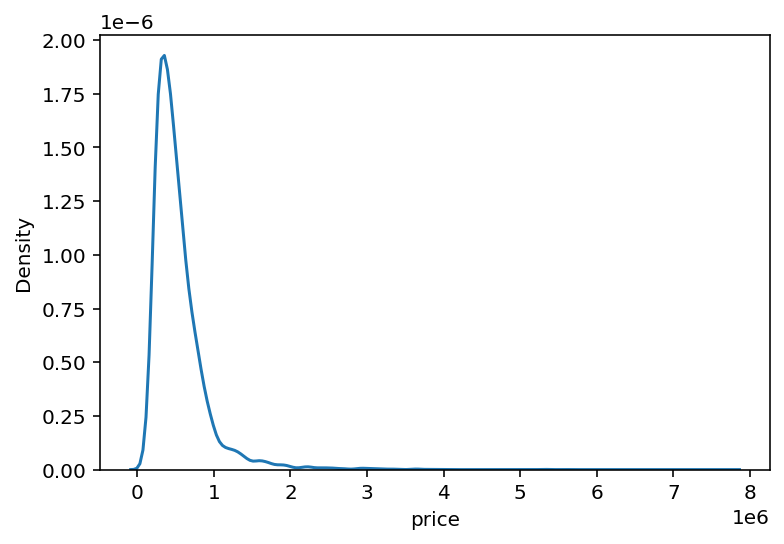

In [11]:
# sns.kdeplot 이용 y 분포 확인

sns.kdeplot(y)
plt.show()

In [12]:
#모델이 너무 0~1에 치우침  np.log1p()로 로그변환 후,
#나중에 np.expm1()활용해 되돌림

y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

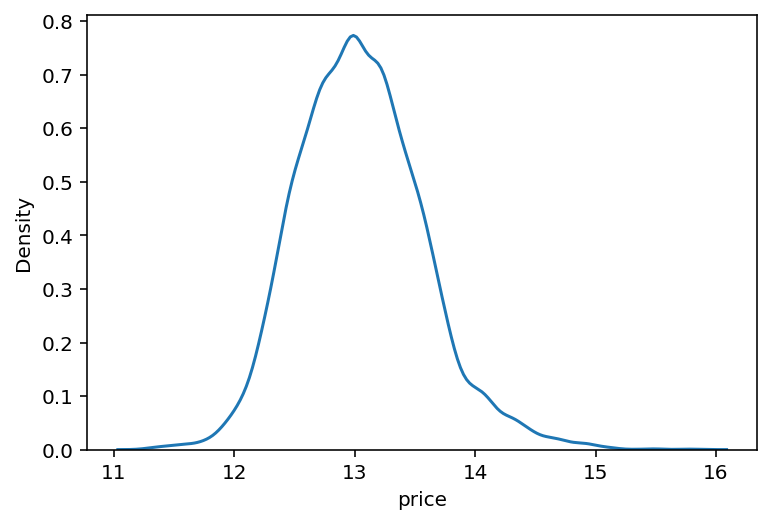

In [13]:
sns.kdeplot(y)
plt.show()

In [14]:
# info() 함수로 데이터의 자료형 한눈에 확인

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print('얍💢')

얍💢


In [16]:
# y_test 나 y_pred는 위에서 np.log1p()로 변환이 된값
#원래 데이터의 단위에 맞게 되돌리기 위해 np.expm1()을 추가해야 한다
#미리 변환해서 rmse를 계산하는 값을 가져옴
#np.sqrt 는 제곱근 구하는 함수

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('얍💢')

얍💢


In [17]:
# 4가지 모델을 가져옴

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('얍💢')

얍💢


In [18]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('얍💢')

얍💢


In [19]:
# 모델의 이름 확인 방법 클래스의 __name__속성에서

gboost.__class__.__name__

'GradientBoostingRegressor'

In [20]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

In [21]:
# 함수 작성
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [22]:
#다향한 파라미터로 확인

from sklearn.model_selection import GridSearchCV

print('얍💢')

얍💢


In [23]:
# param_grid에 탐색할 xgboost 관련 하이퍼 파라미터를 넣어서 준비

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [24]:
#모델 준비 LightGBM

model = LGBMRegressor(random_state=random_state)

print('얍💢')

얍💢


In [25]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [26]:
#실험에대한 결과 확인

grid_model.cv_results_

{'mean_fit_time': array([0.46145768, 0.58752513, 1.20195212, 1.75376134]),
 'std_fit_time': array([0.07536109, 0.16338457, 0.12595613, 0.14283604]),
 'mean_score_time': array([0.03974276, 0.04558401, 0.08362317, 0.11005268]),
 'std_score_time': array([0.01977582, 0.01764721, 0.01208966, 0.0443165 ]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

In [27]:
#어떤파라미터 조합일때 어떤 점수가나오는가 필요한 정보만 빼오기

params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [28]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [29]:
results = pd.DataFrame(params)
results

,max_depth,n_estimators
0,1,50
1,1,100
2,10,50
3,10,100


In [30]:
results['score'] = score
results
#score가 음수인 이유는 성는평가 지표에 neg_MSE 사용했기때문

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


In [31]:
#RMSE 값 구하기
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [32]:
# 사실 RMSE 가아니라 log변환값에서 구한거다 
#이름 변경 RMSLE (Root Mean Squared Log Error)
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [33]:
#낮은순서대로 정렬

results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [34]:
# 그리드 탐색 수행 그 결과를 확인하는 간결한 함수 코드 생성

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [35]:
# 결과 제출 깔끔한 함수로
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [36]:
# 10 100 이 가장 좋은 조합인걸 확인
# 해당 파라미터로 구성된 모델을 준비하고, 학습 후 예측 결과 생성

model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction


array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [37]:
# 예측 결과에 np.expm1()을 씌워서 원래 스케일로 되돌리기

prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [38]:
# 샘플 서브미션 파일 가져오기

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [39]:
# 우리 모델이 예측한 값을 덮어 씌우기

submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [40]:
# 앞으로 많은 실험이 있을 예정임으로 
# 파일 이름에 모델의 종류와 위에서 확인했던 RMSLE 값 넣어서 관리

submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


In [41]:
# 위의 과정들도 하나의 함수로 정리해두기

"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))


In [42]:
# 이 함수를 사용 한줄로 모델을 학습시킨 후 예측 결과를 저장

save_submission(model, train, y, test, 'lgbm', rmsle=0.0168)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!


In [43]:
print(len(train))

15035


In [44]:
### overexploration

# 각 변수의 통계량 확인

X_train.describe().T



,count,mean,std,min,25%,50%,75%,max
date,12028.0,201438.784337,44.351050,201405.0000,201407.000000,201410.0000,201502.000000,2.015050e+05
bedrooms,12028.0,3.367559,0.899637,0.0000,3.000000,3.0000,4.000000,1.000000e+01
bathrooms,12028.0,2.116374,0.772122,0.0000,1.750000,2.2500,2.500000,8.000000e+00
sqft_living,12028.0,2084.368224,929.703868,290.0000,1420.000000,1910.0000,2560.000000,1.354000e+04
sqft_lot,12028.0,15260.023030,40627.696761,520.0000,5023.500000,7620.0000,10608.250000,1.024068e+06
floors,12028.0,1.498462,0.539665,1.0000,1.000000,1.5000,2.000000,3.500000e+00
waterfront,12028.0,0.007399,0.085704,0.0000,0.000000,0.0000,0.000000,1.000000e+00
view,12028.0,0.235451,0.767209,0.0000,0.000000,0.0000,0.000000,4.000000e+00
condition,12028.0,3.408380,0.647220,1.0000,3.000000,3.0000,4.000000,5.000000e+00
grade,12028.0,7.657715,1.181740,1.0000,7.000000,7.0000,8.000000,1.300000e+01


## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평팡피트
21. sqft_lot15 : 근처 15 가구의 부지 평팡피트

In [45]:
# 17,18,19 column 은 우편번호, 위도, 경도, 지리적 위치를 나타내주는 부수 인자로 사용 될수 있는데
# 대체적으로 min_Max 값을 보았을 때 지리적으로 비슷한 지역을 나타낸다 제외
del X_train['zipcode']
del X_train['lat']
del X_train['long']
# 10 column 집이 얼마나 좋아 보이는지의 정도도 집값에 영향을 줄수 있으나 주관적인 지표로 객관화가 떨어지고, 값이 거의 0에 치중되어 제거
del X_train['view']
# waterfront (리버뷰) 또한  12028 개중에 89개 밖에 안됨 outlier로 작용 하거나 모델링 편향도가 떨어지게 만듬 제거
# 높은 비율로 테스트에 워터프론트가 있을 경우 예측 정확도가 떨어질 수 있으나, 동일한 지역의 동일한 확률로 있다고하면 의미가 없다. 

print(X_train['waterfront'].values.sum())
del X_train['waterfront']


89


In [46]:
X_train

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
9705,201408,3,2.50,2580,4636,2.0,3,9,2580,0,2006,0,2480,4500
6045,201503,5,4.00,4460,269345,2.0,3,9,3330,1130,1996,0,2670,115434
9501,201406,4,2.50,2770,10274,2.0,3,9,2770,0,1989,0,2270,7210
8380,201407,3,1.75,1140,10400,1.0,4,7,1140,0,1983,0,1280,9800
2857,201406,3,2.00,1360,5120,1.5,4,6,910,450,1924,0,1440,5120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11971,201405,3,1.00,1340,15600,1.0,4,6,1340,0,1978,0,1320,9800
14966,201503,6,3.00,2390,4000,2.0,3,7,2390,0,2014,0,1680,5000
7491,201408,3,1.00,1090,6125,1.0,4,6,790,300,1945,0,1050,6125
12680,201501,2,1.00,710,4800,1.0,2,6,710,0,1950,0,1480,1721


<AxesSubplot:xlabel='yr_renovated', ylabel='Density'>

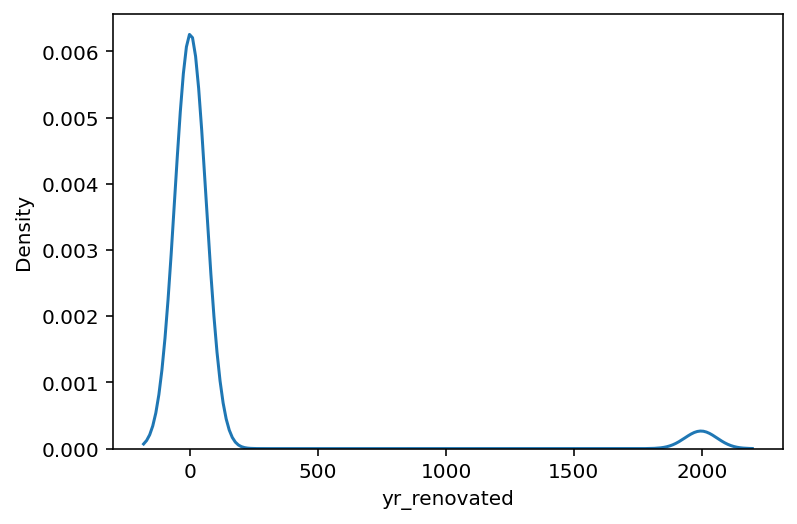

In [47]:
sns.kdeplot(X_train['yr_renovated'])

In [48]:
# 분포자체가 너무 떨어져 있다
# 건물의 내용연수를 표현하기 위해 재건축한 연도가 있으면 재건축 연도를 없으면 준공연도를 표현하는 칼럼을 생성하고 정규화 하자
# 정규화 하는 것보다 당시 시점이 2019 년도 이므로 2019에서 그 값을 뺀 값으로 저장
# 두 칼럼(준공연도, 재건축 연도) 제거

# date 칼럼 년까지로 전처리 부동산 가격변동은 급격하게 변화하지 않으므로 연단위로 구분해도 무방할듯
# 인트로 저장해줬으므로 다시 문자열로 변경한후 4자리까지 제거

X_train['date'] = X_train['date'].astype(str)
X_train['date'] = X_train['date'].apply(lambda i:i[:4]).astype(int)
X_train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
9705,2014,3,2.50,2580,4636,2.0,3,9,2580,0,2006,0,2480,4500
6045,2015,5,4.00,4460,269345,2.0,3,9,3330,1130,1996,0,2670,115434
9501,2014,4,2.50,2770,10274,2.0,3,9,2770,0,1989,0,2270,7210
8380,2014,3,1.75,1140,10400,1.0,4,7,1140,0,1983,0,1280,9800
2857,2014,3,2.00,1360,5120,1.5,4,6,910,450,1924,0,1440,5120


In [49]:
#재건축된 연도 또는 준공 연도를 나타내는 칼럼
# 둘중 큰 값을 추출 한것을 new dataframe으로 저장

yr_new = X_train.loc[:, ['yr_built','yr_renovated']].max(axis=1)

#2019 에서 yr_new를 뺀값을 yr_use 칼럼으로 X_train에 저장

X_train['yr_use'] = 2019- yr_new
X_train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,yr_use
9705,2014,3,2.50,2580,4636,2.0,3,9,2580,0,2006,0,2480,4500,13
6045,2015,5,4.00,4460,269345,2.0,3,9,3330,1130,1996,0,2670,115434,23
9501,2014,4,2.50,2770,10274,2.0,3,9,2770,0,1989,0,2270,7210,30
8380,2014,3,1.75,1140,10400,1.0,4,7,1140,0,1983,0,1280,9800,36
2857,2014,3,2.00,1360,5120,1.5,4,6,910,450,1924,0,1440,5120,95


In [50]:
# 준공년도와 리모델링 칼럼 제거

del X_train['yr_built']
del X_train['yr_renovated']
X_train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,yr_use
9705,2014,3,2.50,2580,4636,2.0,3,9,2580,0,2480,4500,13
6045,2015,5,4.00,4460,269345,2.0,3,9,3330,1130,2670,115434,23
9501,2014,4,2.50,2770,10274,2.0,3,9,2770,0,2270,7210,30
8380,2014,3,1.75,1140,10400,1.0,4,7,1140,0,1280,9800,36
2857,2014,3,2.00,1360,5120,1.5,4,6,910,450,1440,5120,95


In [51]:
# X_test에 관해서도똑같이 진행

del X_test['zipcode']
del X_test['lat']
del X_test['long']
del X_test['view']
del X_test['waterfront']

X_test['date'] = X_test['date'].astype(str)
X_test['date'] = X_test['date'].apply(lambda i:i[:4]).astype(int)



In [52]:
yr_new = X_test.loc[:, ['yr_built','yr_renovated']].max(axis=1)
X_test['yr_use'] = 2019- yr_new
del X_test['yr_built']
del X_test['yr_renovated']

X_test.head()


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,yr_use
2286,2014,2,1.00,1790,4000,1.0,4,7,1040,750,1310,4000,96
13015,2014,2,1.00,890,6430,1.0,3,6,890,0,1460,6430,22
5353,2015,3,1.75,1520,7439,1.0,4,7,1520,0,1650,7500,50
7027,2015,5,2.50,2100,14858,1.0,5,8,2100,0,1980,11730,49
11790,2014,3,2.00,2230,4800,1.5,4,7,1290,940,1650,5040,104


In [53]:
print(len(X_test))

3007


In [54]:
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [55]:
# train에 데이터 전처리 해서 train_n으로 저장

train_n = train.copy()

print(len(train_n))
train_n.head()

15035


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [56]:

del train_n['zipcode']
del train_n['lat']
del train_n['long']
del train_n['view']
del train_n['waterfront']

train_n['date'] = train_n['date'].astype(str)
train_n['date'] = train_n['date'].apply(lambda i:i[:4]).astype(int)

yr_new = train_n.loc[:, ['yr_built','yr_renovated']].max(axis=1)
train_n['yr_use'] = 2019- yr_new
del train_n['yr_built']
del train_n['yr_renovated']

train_n.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,yr_use
0,2014,3,1.00,1180,5650,1.0,3,7,1180,0,1340,5650,64
1,2015,2,1.00,770,10000,1.0,3,6,770,0,2720,8062,86
2,2015,3,2.00,1680,8080,1.0,3,8,1680,0,1800,7503,32
3,2014,3,2.25,1715,6819,2.0,3,7,1715,0,2238,6819,24
4,2015,3,1.50,1060,9711,1.0,3,7,1060,0,1650,9711,56


In [57]:
# 학습시키고 CV밸류 확인
my_GridSearch(model, train_n, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.083446,0.288870
2,10,50,-0.084823,0.291244
1,1,100,-0.104348,0.323029
0,1,50,-0.119524,0.345723


In [58]:
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [59]:
# test data에도 동일하게 작업 했어야함


len(test)
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [60]:
train_n2 = train.copy()

print(len(train_n2))
train_n2.head()

15035


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [61]:
del train_n2['waterfront']

In [62]:
my_GridSearch(model, train_n2, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027699,0.166431
2,10,50,-0.029884,0.172870
1,1,100,-0.055335,0.235233
0,1,50,-0.073356,0.270843


In [63]:
del train_n2['view']

In [64]:
my_GridSearch(model, train_n2, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.029671,0.172252
2,10,50,-0.031788,0.178292
1,1,100,-0.058538,0.241947
0,1,50,-0.075284,0.274380


In [65]:
del train_n2['zipcode']

In [66]:
my_GridSearch(model, train_n2, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.029809,0.172654
2,10,50,-0.031872,0.178528
1,1,100,-0.058538,0.241947
0,1,50,-0.075284,0.274380


In [67]:
del train_n2['lat']
del train_n2['long']

In [68]:
my_GridSearch(model, train_n2, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.078417,0.280031
2,10,50,-0.079785,0.282462
1,1,100,-0.101478,0.318556
0,1,50,-0.117606,0.342937


In [69]:
yr_new = train_n2.loc[:, ['yr_built','yr_renovated']].max(axis=1)
train_n2['yr_use'] = 2019- yr_new
train_n2.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,yr_use
0,201410,3,1.00,1180,5650,1.0,3,7,1180,0,1955,0,1340,5650,64
1,201502,2,1.00,770,10000,1.0,3,6,770,0,1933,0,2720,8062,86
2,201502,3,2.00,1680,8080,1.0,3,8,1680,0,1987,0,1800,7503,32
3,201406,3,2.25,1715,6819,2.0,3,7,1715,0,1995,0,2238,6819,24
4,201501,3,1.50,1060,9711,1.0,3,7,1060,0,1963,0,1650,9711,56


In [70]:
my_GridSearch(model, train_n2, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.078685,0.280508
2,10,50,-0.079770,0.282436
1,1,100,-0.101478,0.318556
0,1,50,-0.117606,0.342937


In [71]:
## 데이터 전처리 (파라미터 제거등)을 통했을때 오히려 오차값이 커진다
# 대부분 결과값에 영향을 주는 것으로 보인다.

#목적변수화 상관관계가 높은 변수를 확인
#다시 원본파일을 데이터프레임 파일로 가져와서 작업해보자
# https://www.kaggle.com/code/chocozzz/house-price-prediction-eda-updated-2019-03-12/notebook?scriptVersionId=11425534
# 리더보드 참고함

# train (전처리한 데이터프레임), y(전처리, 정규화log스케일링) 사용

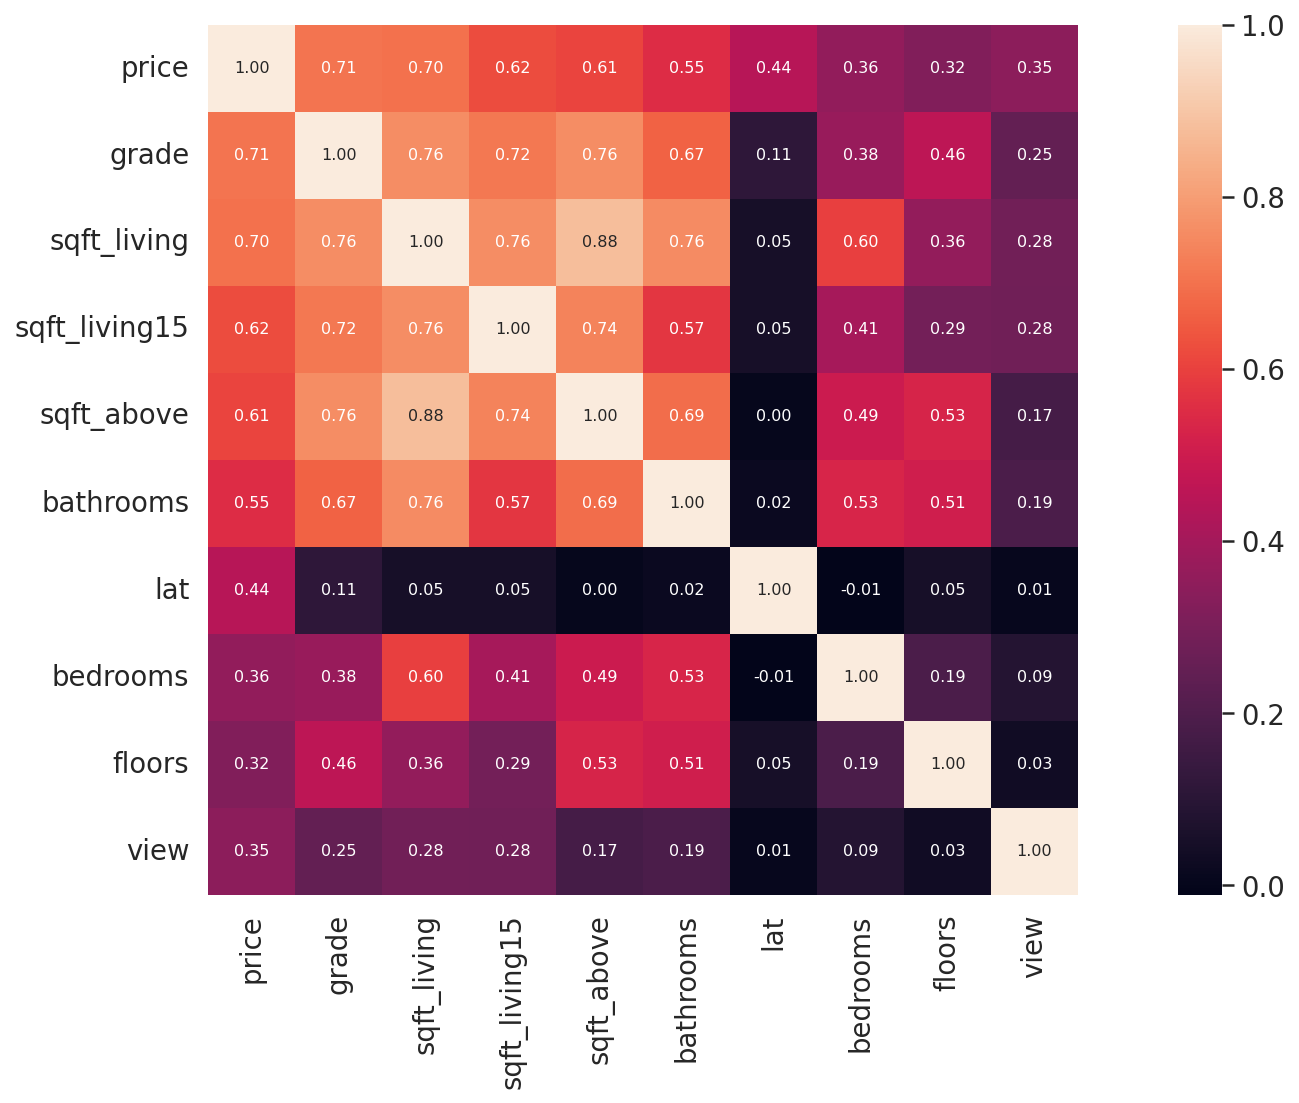

In [75]:
## 데이터 전처리 (파라미터 제거등)을 통했을때 오히려 오차값이 커진
# 대부분 결과값에 영향을 주는 것으로 보인다.

#목적변수화 상관관계가 높은 변수를 확인

#데이터 점검용 데이터프레임 생성 , y값 로그 스케일링으로 정규화
df_train = pd.read_csv(train_data_path)
df_test  = pd.read_csv(test_data_path)


df_train['price'] = np.log1p(df_train['price'])

#saleprice correlation matrix
k = 10 #number of variables for heatmap
corrmat = abs(df_train.corr(method='spearman')) # correlation 전체 변수에 대해서 계산
cols = corrmat.nlargest(k, 'price').index # nlargest : Return this many descending sorted values
cm = np.corrcoef(df_train[cols].values.T) # correlation 특정 컬럼에 대해서
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(18, 8))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [76]:
# 목적변수와 상관도가 높은 변수는 집의 등급, 주거공간의 크기, 전체 크기순이고
# 역시나 위에서 직접 제거했을때 큰 오차를 발생시킨 위도(lat) 값이 들어있습니다.
# 전부 프라이스에 많은(최소 0.32 이상) 영향을 주는것을 알수 있었다.



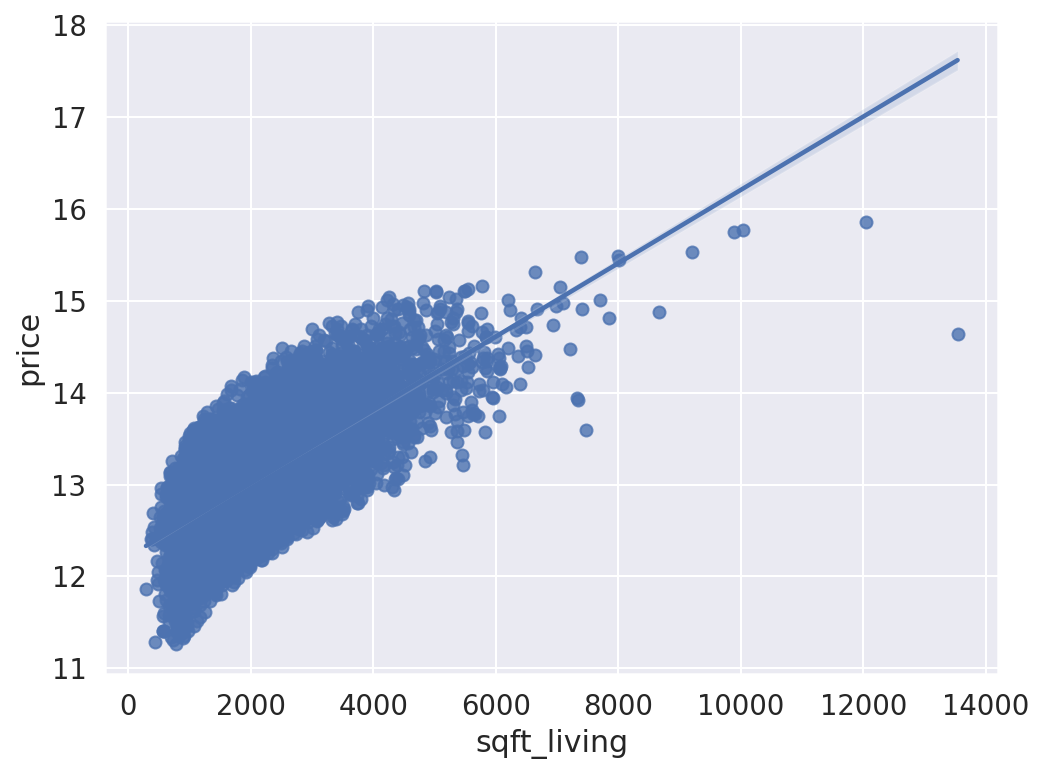

In [78]:
# 이상치 제거

# 위에서 중요한 feature들에 대해 시각화를 해봤을때, 다음의 변수들에 대해 이상치가 있는 것을 확인할 수 있음.
# sqft_living, grade, bedrooms

data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [79]:
df_train.loc[df_train['sqft_living'] > 13000]


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [80]:
# 다른 값들에 비해 sqft_living 만 비정상적임


train.loc[train['sqft_living'] > 13000]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,201405,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [81]:
# 실제 사용할 데이터 프레임인 train 에서 제거
# 인덱스 번호이용 제거 id 칼럼번호 없음

train.drop(train.index[8912])


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [84]:
train.loc[train['sqft_living'] > 13000]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,201405,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [85]:
# drop한거 다시 할당해줘야 함
# 안빠짐

train.shape

(15035, 19)

In [86]:
train = train.drop(train.index[8912])
train.loc[train['sqft_living'] > 13000]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


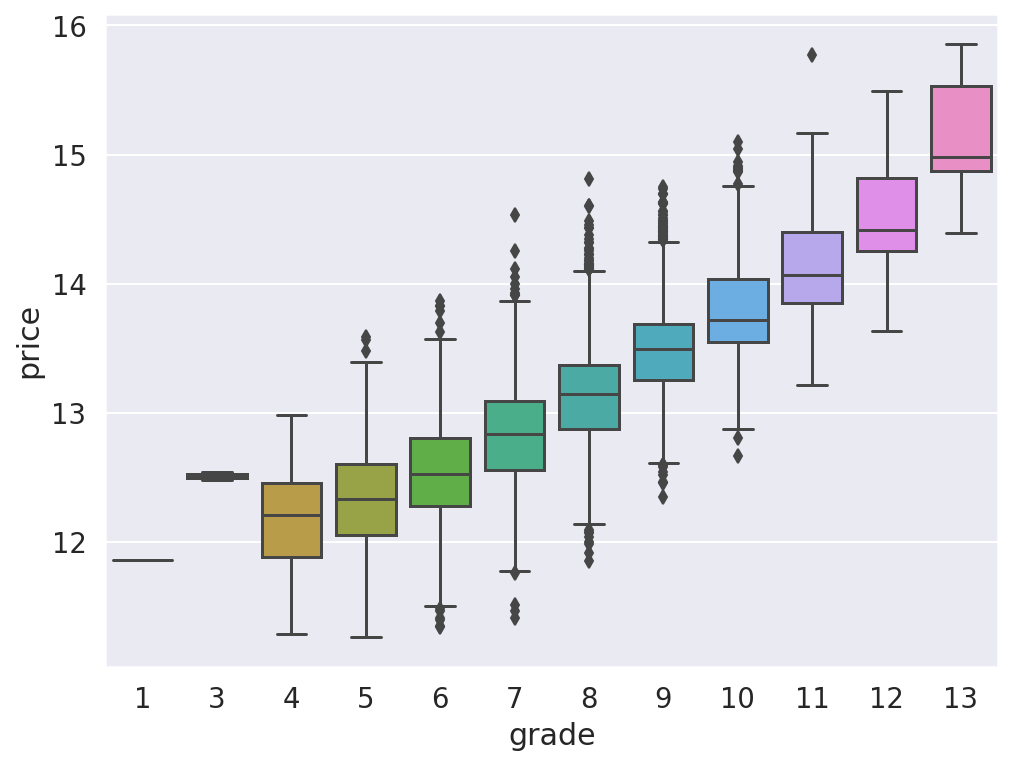

In [87]:
# grade 칼럼 내 이상치 관찰

data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

In [88]:
# 11gade 에서 심한 이상치가 있다
df_train.loc[(df_train['price']>15.5) & (df_train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


In [94]:
# 7과 8 grade 에서도 관찰

df_train.loc[(df_train['price']>14.2) & (df_train['grade'] == 7)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8148,8148,20150430T000000,14.250535,4,2.25,2640,3000,2.0,0,0,...,7,2080,560,1908,0,98109,47.6313,-122.344,1910,3000
12346,12346,20150115T000000,14.533351,4,3.25,3580,19989,1.5,1,4,...,7,3480,100,1915,1965,98125,47.7087,-122.276,2410,6389


In [93]:
df_train.loc[(df_train['price']>14.5) & (df_train['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
983,983,20150511T000000,14.603968,5,4.25,4640,22703,2.0,1,4,...,8,2860,1780,1952,0,98052,47.6393,-122.097,3140,14200
7173,7173,20140813T000000,14.808763,5,4.00,4230,27295,2.0,1,4,...,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295
10037,10037,20140825T000000,14.603968,3,2.00,3570,30456,1.0,0,1,...,8,2070,1500,1946,1982,98039,47.6413,-122.240,3570,27418


In [95]:
# 위 6개 값을 보았을때 특별한 이유 없이 가격이 높아보여
# 이상치로 규정하여 제거

train = train.drop(train.index[2775])
train = train.drop(train.index[8148])
train = train.drop(train.index[12346])
train = train.drop(train.index[983])
train = train.drop(train.index[7173])
train = train.drop(train.index[10037])

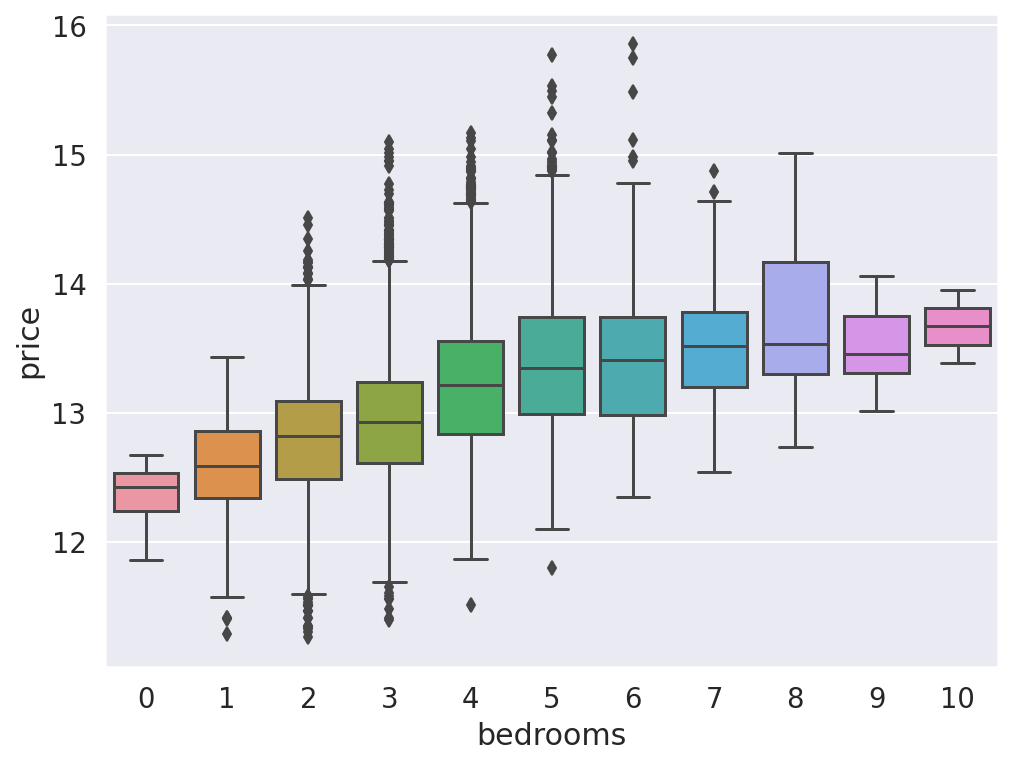

In [96]:
## bedrooms 이상치

data = pd.concat([df_train['price'], df_train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

In [97]:
#train 내에는 대체적으로 베드룸수에 따라 가격이 올라가는 경향을보임
# 10이상인 집은 2개에 불과 베드룸이 비정상적으로 많은 집은 학습집단에 없다.
df_train.loc[df_train['bedrooms']>=10]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
9280,9280,20140814T000000,13.953533,10,5.25,4590,10920,1.0,0,2,...,9,2500,2090,2008,0,98004,47.5861,-122.113,2730,10400
10575,10575,20141029T000000,13.384729,10,2.00,3610,11914,2.0,0,0,...,7,3010,600,1958,0,98006,47.5705,-122.175,2040,11914


In [98]:
df_test.loc[df_test['bedrooms']>=10]
# test에 비정상적으로 베드룸수가 많은 집이 있다. 오차에 영향을 줄것으로 생각


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2584,17619,20140821T000000,11,3.00,3000,4960,2.0,0,0,3,7,2400,600,1918,1999,98106,47.5560,-122.363,1420,4960
4710,19745,20140625T000000,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700
5775,20810,20141229T000000,10,3.00,2920,3745,2.0,0,0,4,7,1860,1060,1913,0,98105,47.6635,-122.320,1810,3745


In [100]:
# 재 모델링
# 학습모델의 타겟 y값에서도 위의 이상치를 제거를 해줘야함

y = y.drop(y.index[8912])
y = y.drop(y.index[2775])
y = y.drop(y.index[8148])
y = y.drop(y.index[12346])
y = y.drop(y.index[983])
y = y.drop(y.index[7173])
y = y.drop(y.index[10037])

my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027094,0.164601
2,10,50,-0.029232,0.170973
1,1,100,-0.055012,0.234547
0,1,50,-0.073208,0.270569


In [101]:
# 이상치 제거 해줬는데 오히려 오차가 미세하게 더 오름
# 데이터 전처리로는 한계가 있는 것으로 보임

[CV] END .......................max_depth=1, n_estimators=50; total time=   0.4s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.6s
[CV] END ......................max_depth=10, n_estimators=50; total time=   1.2s
[CV] END .....................max_depth=10, n_estimators=100; total time=   2.0s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.8s
[CV] END ......................max_depth=10, n_estimators=50; total time=   1.2s
[CV] END .....................max_depth=10, n_estimators=100; total time=   1.8s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.4s
[CV] END ......................max_depth=10, n_estimators=50; total time=   1.2s
[CV] END .....................max_depth=10, n_estimators=100; total time=   1.8s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.5s
[CV] END ...................

In [103]:
# 모델 하이퍼 파라미터 변경

param_grid = {
    'n_estimators': [50, 1000],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,1000,-0.026836,0.163818
2,10,50,-0.029232,0.170973
1,1,1000,-0.036491,0.191026
0,1,50,-0.073208,0.270569


In [104]:
param_grid = {
    'n_estimators': [50, 1000],
    'max_depth': [1, 100],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,100,1000,-0.026972,0.164230
2,100,50,-0.029199,0.170876
1,1,1000,-0.036491,0.191026
0,1,50,-0.073208,0.270569


In [105]:
param_grid = {
    'n_estimators': [50, 1000],
    'max_depth': [1, 50],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,50,1000,-0.026972,0.164230
2,50,50,-0.029199,0.170876
1,1,1000,-0.036491,0.191026
0,1,50,-0.073208,0.270569


In [106]:
param_grid = {
    'n_estimators': [50, 500],
    'max_depth': [1, 25],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,25,500,-0.026521,0.162852
2,25,50,-0.029199,0.170876
1,1,500,-0.039015,0.197523
0,1,50,-0.073208,0.270569


In [107]:
param_grid = {
    'n_estimators': [50, 500],
    'max_depth': [1, 20],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,20,500,-0.026474,0.162707
2,20,50,-0.029199,0.170876
1,1,500,-0.039015,0.197523
0,1,50,-0.073208,0.270569


In [108]:
param_grid = {
    'n_estimators': [50, 500],
    'max_depth': [1, 15],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,15,500,-0.026306,0.162190
2,15,50,-0.029207,0.170900
1,1,500,-0.039015,0.197523
0,1,50,-0.073208,0.270569


In [109]:
param_grid = {
    'n_estimators': [50, 750],
    'max_depth': [1, 15],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,15,750,-0.026643,0.163227
2,15,50,-0.029207,0.170900
1,1,750,-0.037454,0.193530
0,1,50,-0.073208,0.270569


In [110]:
param_grid = {
    'n_estimators': [50, 250],
    'max_depth': [1, 15],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,15,250,-0.026186,0.161820
2,15,50,-0.029207,0.170900
1,1,250,-0.043326,0.208149
0,1,50,-0.073208,0.270569


In [111]:
param_grid = {
    'n_estimators': [50, 200],
    'max_depth': [1, 15],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,15,200,-0.026269,0.162077
2,15,50,-0.029207,0.170900
1,1,200,-0.045157,0.212501
0,1,50,-0.073208,0.270569


##  n_estimators 250

In [113]:
param_grid = {
    'n_estimators': [50, 270], # 250 or270이 최저점인듯
    'max_depth': [1, 15],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,15,270,-0.026186,0.161820
2,15,50,-0.029207,0.170900
1,1,270,-0.042803,0.206888
0,1,50,-0.073208,0.270569


In [114]:
param_grid = {
    'n_estimators': [50, 250], 
    'max_depth': [1, 13],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,13,250,-0.026339,0.162293
2,13,50,-0.029186,0.170839
1,1,250,-0.043326,0.208149
0,1,50,-0.073208,0.270569


In [116]:
param_grid = {
    'n_estimators': [50, 260],
    'max_depth': [1, 15],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,15,260,-0.026187,0.161825
2,15,50,-0.029207,0.170900
1,1,260,-0.043050,0.207486
0,1,50,-0.073208,0.270569


In [117]:
param_grid = {
    'n_estimators': [50, 270], # 250 or270이 최저점인듯
    'max_depth': [1, 17],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,17,270,-0.026277,0.162102
2,17,50,-0.029169,0.170789
1,1,270,-0.042803,0.206888
0,1,50,-0.073208,0.270569


In [118]:
param_grid = {
    'n_estimators': [50, 270], # 250 or270이 최저점인듯
    'max_depth': [1, 15],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,15,270,-0.026186,0.161820
2,15,50,-0.029207,0.170900
1,1,270,-0.042803,0.206888
0,1,50,-0.073208,0.270569


In [119]:
# 'n_estimators':  250 max_depth 15에서 최저점

In [120]:
# 모델학습 시킨후 결과저장

save_submission(model, train, y, test, 'lgbm', rmsle=0.0161)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0161.csv saved!
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=260; total time=   1.0s
[CV] END ......................max_depth=1, n_estimators=260; total time=   1.2s
[CV] END ......................max_depth=15, n_estimators=50; total time=   1.3s
[CV] END .....................max_depth=15, n_estimators=260; total time=   4.7s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=270; total time=   1.2s
[CV] END ......................max_depth=17, n_estimators=50; total time=   1.5s
[CV] END .....................max_depth=17, n_estimators=270; total time=   4.2s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=270; total time=   1.1s
[CV] END ....................

In [121]:
#캐글 제출 오차값은 떨어졌으나, 오히려 캐글 점수는 높아졌다.